# Assignment 10

### 1.复习上课内容

### 2. 回答一下理论题目

#### 1. What is independent assumption in Naive bayes ?

独立性假设指在结果发生的条件下，各个特征同时发生的概率等于结果发生的条件下，各个特征单独发生的概率的乘积

$$p(a_1a_2a_3|v_j)=p(a_1|v_j)p(a_2|v_j)p(a_3|v_j)$$

#### 2. What is MAP(maximum a posterior) and ML(maximum likelihood) ?

MAP最大化后验概率：θ取什么值使得似然p(x|θ)乘以先验p(θ)最大，本质是期望风险最小化
$$h_{MAP} = argmax{p(x|θ)p(θ)}$$

ML最大似然：最大化似然p(x|θ)
$$h_{ML} = argmax{p(x|θ)}$$
即先验概率服从均匀分布，不知道先验知识

#### 3. What is support vector in SVM?

存在一条直线或是一个线性可分超平面，使得样本在特征空间间隔最大

#### 4. What is the intuition behind SVM ?

支持向量机实质是一种 二分类模型，是定义在特征空间上的间隔最大的线性分类器，支持向量机的学习策略就是间隔最大化，实质上就是一个求解凸二次规划的问题。

#### 5. Shortly describ what 'random' means in random forest ?

样本实例中有放回的随机选取一部分组成训练集，剩下的作为预测集
对于每一个节点随机选取一部分特征做决策，选取的特征数目应小于总特征数目

#### 6. What cariterion does XGBoost use to find the best split point in a tree ?

boosting梯度提升方法，XGBoost需要将多棵树的得分累加得到最终的预测得分，且每一次迭代，都在现有树的基础上，增加一棵树去拟合前面树的预测结果与真实值之间的残差遍历所有节点，对于一个目标函数obj=loss+norm，利用泰勒公式二阶展开求导，obj最小，则结构最优。最终得分是每一棵树的对应节点得分相加。

枚举所有不同树结构的贪心法，对于每一个节点feature的选取，选取loss function最小的feature分裂，贪心进行下一步节点的分裂，保证每步最优。

### 3. Practial part

##### Problem description: In this part you are going to build a classifier to detect if a piece of news is published by the Xinhua news agency (新华社）.

#### Hints:

###### 1. Firstly, you have to come up with a way to represent the news. (Vectorize the sentence, you can find different ways to do so online)  

###### 2. Secondly,  pick a machine learning algorithm that you think is suitable for this task

In [158]:
import pandas as pd
import numpy as np
import jieba
import re
import jieba.analyse
import codecs
from collections import Counter
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from gensim import corpora, models, similarities

In [41]:
df = pd.read_csv('./新华社数据/新华社数据.csv', encoding = "gb18030")

In [42]:
df.head()

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm
3,89614,NaN,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""j...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126....
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875...


In [57]:
len(df)

89611

In [58]:
df.columns

Index(['id', 'author', 'source', 'content', 'feature', 'title', 'url'], dtype='object')

In [59]:
df['source'] == '新华社'

0        False
1        False
2        False
3         True
4        False
         ...  
89606     True
89607     True
89608     True
89609     True
89610     True
Name: source, Length: 89611, dtype: bool

In [60]:
df.source[df['source'] == '新华社'] = 1

C:\Users\aceryoung\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
df.head()

,id,author,source,content,feature,title,url
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm
3,89614,NaN,1,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""j...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126....
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875...


In [62]:
df.source[df['source'] != 1] = 0

C:\Users\aceryoung\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
df.head()

,id,author,source,content,feature,title,url
0,89617,NaN,0,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37""...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm
1,89616,NaN,0,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15""...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm
2,89615,NaN,0,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18""...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm
3,89614,NaN,1,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""j...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126....
4,89613,胡淑丽_MN7479,0,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875...


In [64]:
df.shape

(89611, 7)

In [65]:
np.sum(df['source'].values)

78661

In [66]:
np.sum(df['source'].values)/len(df)

0.8778051801676133

In [67]:
content = df['content'].values.tolist()

In [68]:
content[0]

'此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI 9的研发之中。\r\nMIUI 8去年5月发布，距今已有一年有余，也是时候更新换代了。\r\n当然，关于MIUI 9的确切信息，我们还是等待官方消息。\r\n'

In [69]:
len(content)

89611

In [70]:
def token(string):
    return re.findall('\w+', string)

In [71]:
token(content[0])

['此外',
 '自本周',
 '6月12日',
 '起',
 '除小米手机6等15款机型外',
 '其余机型已暂停更新发布',
 '含开发版',
 '体验版内测',
 '稳定版暂不受影响',
 '以确保工程师可以集中全部精力进行系统优化工作',
 '有人猜测这也是将精力主要用到MIUI',
 '9的研发之中',
 'MIUI',
 '8去年5月发布',
 '距今已有一年有余',
 '也是时候更新换代了',
 '当然',
 '关于MIUI',
 '9的确切信息',
 '我们还是等待官方消息']

In [72]:
content_clean = [''.join(token(str(i))) for i in content]

In [73]:
content_clean[0]

'此外自本周6月12日起除小米手机6等15款机型外其余机型已暂停更新发布含开发版体验版内测稳定版暂不受影响以确保工程师可以集中全部精力进行系统优化工作有人猜测这也是将精力主要用到MIUI9的研发之中MIUI8去年5月发布距今已有一年有余也是时候更新换代了当然关于MIUI9的确切信息我们还是等待官方消息'

In [74]:
def cut(string):
    return list(jieba.cut(string))

In [75]:
f = open('./stopwords.txt', 'r', encoding = 'utf-8')
stopwords = [i.strip() for i in f.readlines()]
stopwords[:10]

['为止', '纵然', 'all', '例如', '［④ｅ］', 'when', '亦', '来讲', '谁料', '届时']

In [26]:
target = codecs.open('content_list.txt', 'w', encoding = 'utf-8')

In [27]:
all_words = codecs.open('all_words.txt', 'w', encoding = 'utf-8')

In [28]:
for line in content_clean:
    temp = cut(line)
    line_clean = []
    for word in temp:    #change string to list
        if word in stopwords:
            continue
        line_clean.append(word)
        all_words.writelines(word + '\n')
    drop_ = ' '.join(line_clean) 
    target.writelines(drop_ + '\n')

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\ACERYO~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.094 seconds.
Prefix dict has been built successfully.


In [50]:
f = open('content_list.txt', 'r', encoding = 'utf-8')
content_list = f.read().splitlines()
content_list[:2]

['本周 月 12 日起 小米 手机 15 款 机型 外 机型 暂停 更新 发布 含 开发 版 体验版 内测 稳定版 暂不受 影响 确保 工程师 精力 系统优化 工作 有人 猜测 精力 用到 MIUI9 研发 之中 MIUI8 去年 月 发布 距今已有 一年 有余 更新换代 MIUI9 确切 信息 等待 官方消息',
 '骁龙 835 唯一 Windows10 桌面 平台 认证 ARM 处理器 高通 性能 屏蔽掉 核心 正 联手 微软 找到 一种 适合 桌面 平台 兼顾 性能 功耗 完美 方案 报道 称 微软 拿到 新 源码 Windows10 更好 理解 biglittle 架构 资料 显示 骁龙 835 一款 集成 CPUGPU 基带 蓝牙 WiFi SoC 传统 Wintel 方案 节省 至少 30 PCB 空间 按计划 Q4 华硕 惠普 联想 首发 骁龙 835Win10 电脑 预计 二合一 形态 产品 高通 骁龙 未来 也许 见到 三星 Exynos 联发科 华为 麒麟 小米 澎湃 Windows10 桌面 平台']

In [51]:
f = open('all_words.txt', 'r', encoding = 'utf-8')
all_words = f.read().splitlines()
all_words[:10]

['本周', '月', '12', '日起', '小米', '手机', '15', '款', '机型', '外']

In [76]:
len(content_list)

89607

In [77]:
all_words[:10]

['本周', '月', '12', '日起', '小米', '手机', '15', '款', '机型', '外']

In [82]:
df_content = pd.DataFrame({'content_clean':content_list, 'source':df.source.values[:len(content_list)]})

In [83]:
df_content.head()

,content_clean,source
0,本周 月 12 日起 小米 手机 15 款 机型 外 机型 暂停 更新 发布 含 开发 版 ...,0
1,骁龙 835 唯一 Windows10 桌面 平台 认证 ARM 处理器 高通 性能 屏蔽掉...,0
2,此前 一加 3T 搭载 3400mAh 电池 DashCharge 快充 规格 5V4A 电...,0
3,这是 月 18 日 葡萄牙 中部 佩德罗 冈 地区 拍摄 森林 大火 烧毁 汽车 新华社 记...,1
4,原 标题 44 岁 女子 跑 深圳 约会 网友 拒 暴雨 中 裸身 奔走 深圳 交警 微博称...,0


In [87]:
df_words = pd.DataFrame({'all_words':all_words})

In [91]:
words_count = df_words.groupby(by=['all_words'])['all_words'].agg(count = np.size)
words_count = words_count.reset_index().sort_values(by=["count"],ascending=False)

In [92]:
words_count.head(10)

,all_words,count
24192,n,382003
154058,月,189330
148323,日,166300
146162,新华社,142462
118804,年,123106
96807,外代,83268
34946,中,73926
35437,中国,71179
5421,2017,69894
230984,记者,62146


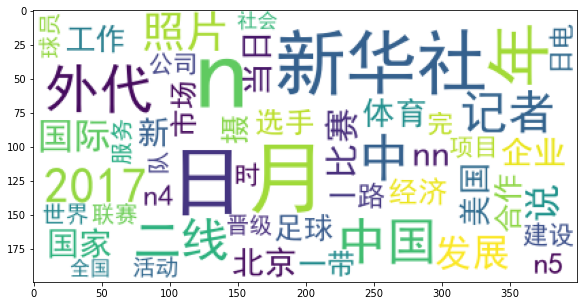

In [93]:
# 词云
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

wordcloud=WordCloud(font_path = r'C:\Windows\Fonts\simhei.ttf',background_color="white",max_font_size=80)
word_frequence = {x[0]:x[1] for x in words_count.head(50).values}
wordcloud=wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud)

In [97]:
#TF-IDF
print(content_list[0])
print(' '.join(jieba.analyse.extract_tags(content_list[0], topK = 5, withWeight =  False)))

本周 月 12 日起 小米 手机 15 款 机型 外 机型 暂停 更新 发布 含 开发 版 体验版 内测 稳定版 暂不受 影响 确保 工程师 精力 系统优化 工作 有人 猜测 精力 用到 MIUI9 研发 之中 MIUI8 去年 月 发布 距今已有 一年 有余 更新换代 MIUI9 确切 信息 等待 官方消息
MIUI9 机型 精力 体验版 系统优化


In [102]:
dictionary = corpora.Dictionary(df_content[content_clean])
corpus = [dictionary.doc2bow(sen) for sen in df_content[content_clean]]
lda = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = dictionary, num_topics = 20)

KeyError: "None of [Index(['此外自本周6月12日起除小米手机6等15款机型外其余机型已暂停更新发布含开发版体验版内测稳定版暂不受影响以确保工程师可以集中全部精力进行系统优化工作有人猜测这也是将精力主要用到MIUI9的研发之中MIUI8去年5月发布距今已有一年有余也是时候更新换代了当然关于MIUI9的确切信息我们还是等待官方消息',\n       '骁龙835作为唯一通过Windows10桌面平台认证的ARM处理器高通强调不会因为只考虑性能而去屏蔽掉小核心相反他们正联手微软找到一种适合桌面平台的兼顾性能和功耗的完美方案报道称微软已经拿到了一些新的源码以便Windows10更好地理解biglittle架构资料显示骁龙835作为一款集成了CPUGPU基带蓝牙WiFi的SoC比传统的Wintel方案可以节省至少30的PCB空间按计划今年Q4华硕惠普联想将首发骁龙835Win10电脑预计均是二合一形态的产品当然高通骁龙只是个开始未来也许还能见到三星Exynos联发科华为麒麟小米澎湃等进入Windows10桌面平台',\n       '此前的一加3T搭载的是3400mAh电池DashCharge快充规格为5V4A至于电池缩水可能与刘作虎所说一加手机5要做市面最轻薄大屏旗舰的设定有关按照目前掌握的资料一加手机5拥有55寸1080P三星AMOLED显示屏6G8GBRAM64GB128GBROM双1600万摄像头备货量惊喜根据京东泄露的信息一加5起售价是xx99元应该是在279928992999中的某个',\n       '这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车新华社记者张立云摄',\n       '原标题44岁女子跑深圳约会网友被拒暴雨中裸身奔走深圳交警微博称昨日清晨交警发现有一女子赤裸上身行走在南坪快速上期间还起了轻生年头一辅警发现后赶紧为其披上黄衣并一路劝说她那么事发时到底都发生了些什么呢南都记者带您一起还原现场南都记者在龙岗大队坂田中队见到了辅警刘青发现女生的辅警一位外表高大帅气说话略带些腼腆的90后青年刘青介绍6月16日早上7时36分他正在环城南路附近值勤接到中队关于一位女子裸身进入机动车可能有危险的警情随后骑着小铁骑开始沿路寻找大概花了十多分钟在南坪大道坂田出口往龙岗方向的逆行辅道上发现该女子女子身上一丝不挂地逆车流而行时走时停时坐时躺险象环生刘青停好小铁骑和另外一名巡防员追了上去发现女子的情绪很低落话不多刘青尝试和女子交流劝说女子离开可女子并不愿意接受继续缓慢地往南坪快速路的主干道上走去此时路边上已经聚集了很市民围观为了不刺激女子的情绪刘青和巡防员一边盯着女子一边驱赶着围观的群众现场还原从警方提供的一份视频了解到16日早上7时25分女子出现在坂雪岗大道与环城南路的监控视频中此时女子还穿着白色的内裤正沿着坂雪岗大道往南坪快速的方向缓慢地走着当时正值上班高峰期十字路口的车流已经排起了长队当女子出现时路上的市民纷纷驻足观望不少车辆也放慢了速度但女子并不为市民观望停下脚步依然缓慢走着当女子行进到十字路口中间时一辆大货车挡住了镜头但是当女子再次出现镜头时可以发现女子已经没穿内裤了全身裸露继续朝着南坪快速方向走去记者发现视频中女子周围并没有人尾随或者上前劝止的市民一大清早路上看到这样的情况恐怕大家都没办法淡定面对这一情况刘青表示一开始根本不敢看她心里挺别扭感觉很尴尬但当刘青跟随女子上了南坪快速路主干道时女子作出了让人意想不到的举动她突然靠近护栏要从上面跳下去刘青赶忙冲上去拉住了女子的手将其控制住并远离护栏碍于女子没有穿衣服刘青递上衣服女子没接受还把衣服扔到排水沟里继续往前走没办法刘青只能紧紧拉着她的一只手跟在后面刘青一路上耐心地开导安慰她但只听到她不断地重复着一句话要是你也遭遇我的事你也会这样的期间她还不时试图挣脱刘青的手要冲向护栏往下跳就这样我被牵着走了大概十多分钟天突然下起了大暴雨雨大的连眼睛都睁不开刘青继续说着瞬间他们就被雨透了但女子依然不愿意接受刘青的帮助就继续冒着大雨往前走大概走了有四十分钟吧女子突然停下来说我想回家了然后女子也接受了刘青递过来的小黄衣就出现了深圳微博上的照片女子披着小黄衣刘青小心翼翼地在旁边走着的场景从南平快速下来后刘青和巡防员将女子带到了附近的坂田派出所那姑娘到底是遭遇了什么样的事情才会说要是你也遭遇我的事你也会这样据警方透露该女子姓陈系湖北人今年44岁据家属反映其有精神病史三天前陈某从老家来深圳约会网友但约会受挫导致情绪异常女子遂产生轻生念头目前陈某已经被送往深圳某精神病医院进行治疗大大君只希望姑娘能早点康复其实真爱的到来并不存在年龄的限制你们说呢因善良的原因一众网友纷纷为交警暖男点ZAN弓常yan桦就想问这个小哥哥有女票吗原谅我这一辈子浪荡不羁爱萨摩耶有什么过不去的要轻生嘛想想自己的家人同时也感谢交警蜀黍火心聆听心灵点赞交警中華云盾警察警察就是群众最需时申出援手Tomchlee蜀黍帅SJ李赫海i这个交警很暖有木有男子迷奸网友拍418个视频女方从20岁到50岁不等去年6月7号上午淮安市涟水县公安局刑警大队突然接到了一个奇怪的报警电话一名女子言语不清声称自己遭到了侵害女子被侵害言语不清几个关键词令接到电话的民警瞬间紧张起来',\n       '受到A股被纳入MSCI指数的利好消息刺激A股市场从周三开始再度上演龙马行情周四上午金融股和白马股表现喜人但是尾盘跳水之后仅金融板块仍维系红盘状态分析人士认为金融股受益于MSCI纳入A股和低估值而重获资金青睐但是存量资金博弈格局下风格交替的震荡格局料延续流动性改善经济悲观预期修正等有助于支撑板块继而大盘指数逐步向好一九再现周四A股市场未能延续周三的上行态势两市成交小幅放量29个中信一级行业中收盘仅银行和非银行金融两个行业指数收红分别上涨180和020从二级行业来看股份制与城商行的涨幅最高达到222国有银行上涨082信托及其他上涨064保险板块上涨034证券板块上涨006银行板块25只成分股中共有21只收红其中招商银行涨幅最大上涨666贵阳银行上涨365上海银行华夏银行浦发银行和兴业银行的涨幅均超过150非银行金融板块44只成分股中共17只个股上涨其中安信信托中国太保涨幅居前两名分别上涨457和304西水股份华安证券中国人寿和新华保险的涨幅也均超过2相对而言券商股多小幅下跌近期对A股市场消息面影响最大的就是MSCI宣布从2018年6月开始将A股纳入MSCI新兴市场指数而其中金融股是占比最大的一个群体国金证券李立峰团队指出最新方案中包含的222只成分股中剔除了中等市值非互联互通可交易的股票以及有停牌限制的标的由于纳入了很多大市值AH股A股在MSCIEM中的权重由05上升到了073其中金融板块占比最高达到4011泛消费次之占比为2426两个板块涵盖了大部分权重股动态来看由于加入了很多是指占比高的金融公司金融板块的权重增加了近一半其他大部分行业权重都受到了稀释尽管A股被纳入MSCI这一利好事件对短期市场情绪有所提振对中长期海外增量资金预期升温但短期内市场量能尚不能有效放大金融股独乐乐情景也就难以持续存量博弈格局下风格交替指数震荡格局难改变光大证券指出利好并未引起市场太大的热情两市指数和成交量均较为平淡但市场风格出现了较大变化白马股金融股上涨的同时成长股题材股全天低迷这表明市场增量资金依然很少存量资金在不同板块之间腾挪这样的跷跷板格局使得指数难有突破市场中期依旧偏空短期依旧可能维持震荡格局',\n       '虽然至今夏普智能手机在市场上无法排得上号已经完全没落并于2013年退出中国市场但是今年3月份官方突然宣布回归中国预示着很快就有夏普新机在中国登场了那么第一款夏普手机什么时候登陆中国呢又会是怎么样的手机呢近日一款型号为FS8016的夏普神秘新机悄然出现在GeekBench的跑分库上从其中相关信息了解到这款机子并非旗舰定位所搭载的是高通骁龙660处理器配备有4GB的内存骁龙660是高通今年最受瞩目的芯片之一采用14纳米工艺八个Kryo260核心设计集成Adreno512GPU和X12LTE调制解调器当前市面上只有一款机子采用了骁龙660处理器那就是已经上市销售的OPPOR11骁龙660尽管并非旗舰芯片但在多核新能上比去年骁龙820强单核改进也很明显所以放在今年仍可以让很多手机变成高端机不过由于OPPO与高通签署了排他性协议可以独占两三个月时间考虑到夏普既然开始测试新机了说明只要等独占时期一过夏普就能发布骁龙660新品了按照之前被曝光的渲染图了解夏普的新机核心竞争优势还是全面屏因为从2013年推出全球首款全面屏手机EDGEST302SH至今夏普手机推出了多达28款的全面屏手机在5月份的媒体沟通会上惠普罗忠生表示我敢打赌12个月之后在座的各位手机都会换掉因为全面屏时代的到来我们怀揣的手机都将成为传统手机',\n       '沙漠雄鹰震荡有利消化套牢筹码周四开盘上证50在银行券商大蓝筹带动下一度涨近2沪指也一度站上60日与120日均线但在黑天鹅万达电影暴跌拖累下沪深股市绝大多数时间分道扬镳14点后次新股大幅跳水令各大指数全线收绿存量博弈格局难改量能久日不见放大下蓝筹行情并不可持续短线策略依然是以题材为主次新股和区域经济概念股调整压力仍然突出成长股再次大跌但目前处于底部低位反复震荡有助于夯实底部目前市场仍属存量资金博弈短期蓝筹股上演的指数行情令市场承压短期利好带动的蓝筹股行情或将告一段落后期需要题材股接力来维稳指数走向今日经财要闻一央行上海总部发布债券通北向通境外投资者准入备案业务指引二我国信用法规和标准研究正在加快推进三上海易居房地产研究院发布的房贷利率与楼市研究报告显示近期许多城市的个人住房贷款利率均有不同程度的上涨四水污染防治法修正案草案二审更大力度保护水环境五根据中国结算发布的关于开展存量一人多户休眠工作的通知已启动对同一投资者开立的三户以上多开账户的休眠工作按中国结算的文件要求自6月23日后的下一交易日下周一6月26日起被确认为休眠账户的将在交易系统中止交易六李军十三五末上海金融市场交易额或达2000万亿七受A股纳入MSCI新兴市场指数以及中国宏观环境持续稳定的双重因素鼓舞下富达国际基金经理马磊表示预计2017年下半年中国股市投资者情绪将有望转好中国股市未来十年增长将主要由创新驱动大盘回顾周四A股市场出现了早盘冲高午市后震荡回落尾盘大幅跳水的走势从盘面看沪深300指数盘中创17个月新高但2000余只个股下跌市场分化相当明显至收盘上证指数报314745点较前一交易日跌876点跌幅为028深成指报1026520点跌10197点跌幅为098创业板指表现最弱报179838点跌幅达到144两市个股普跌仅400余只交易品种上涨不计算ST股和未股改股两市涨停个股不足30只两市共成交4781亿元较前一交易日大增800多亿元数据显示昨日两市共有主力尽流出19057亿元较上一日的9695亿元大增9627两市61个行业板块有57个遭遇主力抛售虽然券商与银行板块共有近13亿元主力介入但化工行业与医药制造就分别遭遇14亿元与1221亿元的主力抛售而持续低迷的雄安新区的抛售力度更是高达4169亿元技术分析昨日临近收盘的半个小时沪指上演高位跳水将涨幅全部回吐失守60日均线成交量明显放大留下长长的上影线尽管跌幅不深但个股一地鸡毛沪指自3016点以来大盘每次回调的相对低点位置都在不断抬升所以即使大盘冲高乏力后出现回落指数调整的空间也因被封住而难以出现大跌总体来说市场震荡分化的格局短期依然难以打破短线来看沪指在盘中攻克60日均线和半年线压力之后却在当日得而复失而创业板指则连上方均线压力都无法触及这样的走势无疑会对投资者心理产生负面影响而在技术形态上在60分钟K线级别已经形成了背离雏形一旦沪指跌破3117点就意味着背离成型如此即可能引发日线级别的下跌综合分析目前指数正处在压力区间市场脆弱的心态碎片化的涨停板主线模糊热点凌乱赚钱效应弱等因素都是大盘突破的掣肘因素而昨日的尾盘跳水主要有以下原因首先长期的二八分化导致人气低迷最近一段时间权重股虽然整体走高但该板块群众基础弱弹性小制约绝对涨幅难以形成大面积的赚钱效应与此同时现在场内二八轮动非常频繁今天追进的资金明天就要吃套打击资金积极性其次市场反弹到重要压力区却仅靠资金拉升指标股来抬升指数这种没有赚钱效应的拉抬是不可能持久的昨日招商银行一度大涨7但投资者似乎并不买账跟风盘极少由于目前A股一直是存量资金博弈的市场所以指标股吸引着资金加码那么就意味着中小市值品种面临着强大的筹码套现压力另外昨日万达股票债券莫名齐跌午后复星医药盘中突现闪崩令市场踩踏事件出现短期市场受此影响再次收复上方半年线的压力大增投资建议近期权重蓝筹一直强于中小创但上涨始终缺乏有效的量能支持在存量博弈背景下后续资金若无法跟上活跃资金或会转战中小创短线投资者在降低权重配置时可加大中小创中盘子小股性活跃的超跌品种大盘的纠缠格局依然还在进行中权重股虽整体走高但群众基础弱弹性小绝对涨幅有所制约金融板块大涨促使沪指上摸3180点压力位区间但能否真正有效突破还需要观察几日基于周四K线组合形态偏向悲观因此投资者当前宜先退出观望等待股指下方获得支撑后再寻机操作热点分析由于粤港澳大湾区论坛期间腾讯看多人工智能百度也将于7月5日举办百度AI开发者大会以谷歌亚马逊为代表的互联网巨头一致看好人工智能未来的发展产业创新叠加政策扶持人工智能行业高景气度有望维持市场在最近一个月内出现了4次长上影线之前三次都形成了周线级别调整加之下周是月末钱荒效应值得股民做好应对自6月初以来市场始终是以中小创为首的反弹模式个股赚钱效应保持而随着周三尾盘开始权重股快速拉升带来了指数尾盘翻红周四刷新高点但与此同时个股赚钱效应却有了明显的降温的个股涨少跌多午盘后个股跳水加剧这一现象必须要引起重视玉名认为这意味着上证50创新高但并没有带来其余个股的跟随相反还带来了大部分个股的跳水而受到政策红利的军工板块和上周王者荣耀引发的手游股类似都是出现了一日游的走势没有延续性的热点更多地来自于事件刺激和超跌反弹市场下周将进入到一个比较敏感的时间段既是月末季末又是半年末容易出现资金的异动实际上从美联储加息和缩表行为来看已经意味着紧缩货币政策的开启而这也在全球央行中流行金融市场很难再现大水漫灌式强刺激中性偏紧的政策和流动性将成为一种常态从基本面来看玉名认为中国经济仍将是L型筑底走势这是一个阶段是一段较长的时间意味着没有高速增长也没有增速大幅下滑而是横盘周期同时以适度偏紧的政策为供给侧结构性改革提供良好环境因此从基本面决定了股市只能处于震荡市周期技术上沪指运行到60日均线附近在权重股拉升之下有突破之意不过由于运行到前期肩部区域压力还是比较大这种单纯依托权重股而忽略个股效应的模式能够走多远还是值得担忧的这是引发资金派发而形成跳水的关键因素尤其是个股的赚钱效应越来越差甚至不排除一些获利盘和解套盘选择了短线的离场伴随着高位资金追涨的压力也在增加谨慎观望气氛增加导致了成交量的止步不前玉名认为目前股民需要对于个股做一个梳理了短线反弹较多的且近期放量滞涨的就要有所警惕了要逐步兑现利润选择落袋为安重新等待机会而对于已经进入前期阻力区或密集套牢区的个股应该及时考虑减仓毕竟这样的品种很容易出现再度的调整对于前期涨幅不大或者是下跌通道已经扭转的个股可以暂时持有观望昨日回顾主板终于费尽九牛二虎之力爬到了3180点附近但是遗憾的是在主板尤其是上证50和沪深300不断地创新高之际中小创却依然是忍受着无厘头的煎熬午后市场更是以全线跳水的结局收盘那么对于这样的市场周五会怎样昨日消息面央行债券通登记托管等实施细则会很快发布实施发改委抓紧制定出台配气价格监管规则人社部9月底前基本实现跨省异地就医住院费用直接结算23日成品油将迎年内第六次下调降幅或达270元吨国防科工局推进军工企业混改加快军工资产证券化进程广电总局要求新浪微博等网站关停视听节目欧美股指延续涨跌不一的走势消息面上外围市场整体稳健国内信息面则继续是不死不活的形式预计市场继续走整理行情技术分析技术上看市场昨日走势在午后全线跳水主板创新高后回落创业板则是继续在1800点附近做整理相比于主板则显得较为弱势技术上看市场周五将依然不会有大行情但是二八转换的格局将可能随时出现今日大盘下档第一支撑位在3130点第二支撑位在3100上档第一压力位在3160点第二压力位在3180点今日走势欧美股指高位整理隔夜信息面依然没有什么实质性的利好今天继续有新股申购在这样的情况下预计大盘再度平开或小幅低开可能性大整体看今天指数出现调整的可能性大日线继续以小阴小阳或十字星线为主随时防止主板可能出现的回调今日操作就昨日市场的走势看依然是面子行情更是将中小创再度推到了一个极为尴尬的境地当然在筑底的过程中很多的不确定因素将会愈发明显因此建议大家操作继续在短期寻求涨幅不大的个股或者是底部放量的个股尤其是再加上业绩稳定的个股将是最好逢低介入操作上短期建议执行快进快出的策略远离短期涨幅过大的个股具体操作坚持大涨卖大跌买不涨不跌选择观望的策略从昨日市场走势看又一次证明了彬哥之前所让大家关注的3180点主板可能回调的观点是正确的而主板也确实在3180点附近出现了回调对于这样的回调彬哥认为是一个健康的事情也是一个必须要出现的事情现在唯一不能确定的就是在主板回调的时候中小创会不会出现企稳会不会出现让投资者操作的机会因此大家今天上午需要至少需要半天的时间去观察市场可能出现的结果目前行情有一点可以确定的就是主板将会在3180点附近出现调整因此大家万不可在这个时候再去追涨主板的个股尤其是以保险银行为首的上证50个股就周四午后市场的走势看主板的调整势在必行因此大家要做好主板调整的心理准备当然还要做好市场全线调整的心理预期',\n       '原标题武汉警方一下子抓了808人还都是俊男靓女原来他们每天偷偷摸摸干这事武汉警方一下子抓了808人还都是俊男靓女原来他们每天偷偷摸摸干这事大家还记得今年4月光谷曾发生的一件大事吗当时微博和朋友圈上都传疯了说是光谷国际广场大量白领被捕现场手铐都不够用结果经记者深入调查后发现这些被抓的并不是网传的白领而是一个有282名涉案人员的诈骗团伙天呐接近300人的犯罪团伙你以为这个数字已经够庞大了吗错还有让你更震惊的据武汉市公安局通报6月9日警方在武汉三镇的10处窝点内抓获了808名嫌疑人而且令人大跌眼镜的是他们当中大多都是年青人用俊男靓女来形容也不为过年纪不大外形不差那么到底是犯了什么事呢其实说起来这事估计绝大多数人都碰到过那就是网络诈骗涉案电脑800余台手机2000余部银行卡3000余张因为涉及的账户太多涉案金额目前还没统计出来这是全国涉案人数最多的一起特大网络诈骗案这些惊人的数字背后究竟藏着什么样的秘密警方把他们一锅端了今年4月武汉警方获悉在塔子湖地区有电信网络诈骗活动经过2个多月的秘密侦查发现了一个特大网络诈骗犯罪团伙原来该团伙利用非法互联网金融平台实施推荐股票炒期货等诈骗其10处窝点散布在江岸洪山东湖高新硚口江汉等5个区的写字楼内涉案人员多达800余名6月9日上午武汉警方组织了1000余名警力分成14个抓捕组同时对首脑分子和10处窝点实施了突击抓捕行动目前警方已依法刑事拘留411人对45人取保候审该案还在进一步调查中他们是如何进行诈骗的人数众多的这个诈骗组织是怎么样进行人员分工又是如何一步步引受害人上钩的呢2015年以来该犯罪团伙以投资组建的某集团公司为总部旗下成立多家分公司子公司设立人事部财务部行政部等机构部门分为经理分析师业务小组长业务员等组织层级在网上发布招聘信息招揽培训业务员依托虚构的互联网金融平台通过业务员散布有内幕消息等虚假信息引诱受害人加入专门的QQ群微信群再由所谓的证券公司资深分析师和经理逐个联系受害人引诱受害人交易股票期货贵金属外汇等金融产品受害人若获利则按五五六四分成若亏损则拉入黑名单不再联系网友热评李晓猫不吃鱼在人信汇写字楼面试过一个这种工作一听不对劲就撤了说不适合我我嘴巴笨习惯就好33xxzz八百多人可能相当部分人都不大清楚自己到底是啥性质工作吧刑法守望者要警惕了普法各种工作都要预防法律风险要做个明白人不是什么钱都可以拿尤其是从事金融保险银行财务的人员不小心就触犯刑法童颜永在心理医生盘在写字楼内的诈骗公司以高薪招聘业务人员为诱饵实行诈骗的顽疾终于被揣掉了你的渔船联系一下自己的朋友看有多少个被抓了Theformerdegrees招聘平台和销售会上百分之八十就是这种工作从源头抓起防止更多人受伤宇宇家的小仙女恐怖进了一个星期发现不太对劲这尼玛是让我骗人啊赶紧自己跑路了z_路漫漫我做过后来听说公司跑路了睡不饱怎么办啊小铭大我都面试过这种工作还培训了几天话术一看就的套路骗果断闪人这种公司太多了遗忘的金叶子碰到这样的骗子找我们做视频最后被我打电话骂了一顿a一元复始c还有那些天天电话骚扰别人信贷的卖房的卖邮票的发票的社会生活中一不留神就会被坑所以活着需要理智笑看世间丑2448337651这是在路上发骗广告搞高利贷的那些互联网金融公司吗未来温暖的时光属于自己金融港街道口都是这些好多同学刚刚毕业都去做过都是网上投简历这些公司就猛联系你其实好多都不知道这是骗人的吧有强迫症的天蝎座怪咖吓到我了冉冉的彗星是个宝早上还接到说做期货霖心金鱼And张蒙都不敢去找工作了蒋妈妈15刚回到武汉准备找份工作看网上好多这种招聘的感觉像骗人的都不看的看了网友的评论小编只有一个感觉找工作时一定要擦亮双眼不要因为一时疏忽而给自己的生活抹上污点俗话说知己知彼百战不殆弄清网络诈骗的常见手法才能避免上当受骗下面就为大家奉上防骗攻略遇到诈骗只需见招拆招网络防骗攻略电信网络诈骗犯罪往往表现为六大陷阱1物美价廉的网购陷阱2推销产品的便利陷阱3异性交友的情感陷阱4中奖信息的惊喜陷阱5冒充国家工作人员的恐吓陷阱6钓鱼网站和网上银行的迷惑陷阱下面是网络诈骗中比较常见的几种类型一起学习如何防范让骗子无处遁形1虚假红包诈骗临近节日时各大电商平台会以派发红包的形式为促销活动预热有不法分子趁机在微信朋友圈微信群等平台中派发虚假红包诱骗大家点击套取个人信息或传播木马病毒盗取银行账号识骗方法慎点此类红包领取链接如果不小心点击应第一时间关闭手机网络修改网银支付宝等重要账户密码并通过安全软件查杀木马病毒2二维码诈骗抢购高峰期网页打开慢网银交易出现比较迟钝现象有不法分子会冒充客服或店主以单子出现调单卡单等说法为幌子故意说没有收到款项欺诈消费者取得信任后要求消费者以其他办法进行转账识骗方法消费者要注意调单卡单激活订单等多为诈骗术语见此类词语基本可以断定对方是骗子没有收到款项这样的问题是不会在东京天猫这样的大型网络购物平台出现的3钓鱼网站诈骗节假日期间公众的购物热情高涨假冒正规电商官方网站在线支付平台等的钓鱼网站活动频繁消费者在忙于浏览各色商品页面时往往容易忽略链接的安全性从而误入诈骗分子发来的虚假钓鱼网站识骗方法对陌生人发来的商品链接要提高警惕谨慎打开如遇网络诈骗应第一时间向属地公安机关报案并向举报中心举报4虚假客服诈骗抢购高峰期网页打开慢网银交易出现比较迟钝现象有不法分子会冒充客服或店主以单子出现调单卡单等说法为幌子故意说没有收到款项欺诈消费者取得信任后要求消费者以其他办法进行转账识骗方法消费者要注意调单卡单激活订单等多为诈骗术语见此类词语基本可以断定对方是骗子没有收到款项这样的问题是不会在东京天猫这样的大型网络购物平台出现的5预购诈骗还有不法分子会以提前购预售为诱饵向用户发送木马链接除了网购链接被植入木马钓鱼网站还有不法分子会在预售活动上做文章骗取买家定金识骗方法慎点不明链接有关购物短信也不要轻信同时也请给手机装上杀毒软件提供安全的上网环境6中奖诈骗购物过后很多人会陆陆续续收到一些商家的中奖信息切记不要随意拨打中奖信息提供的电话号码或点击发来的网站链接地址很可能会让手机或电脑感染上木马病毒识骗方法收到中奖信息后留心一下看一看你所购买的产品中有没有这家的产品然后最好能在天猫店里直接和卖家联系确认消息7朋友圈诈骗由于缺少第三方监管平台不法分子会在朋友圈发布虚假低价购物信息骗取消费者汇款购买识骗方法朋友圈里的销售行为存在取证难查处难的问题因此建议大家在朋友圈买东西时尽可能选择正规第三方支付平台进行支付避免直接支付以确保安全8快递诈骗不法分子会从非法渠道获得客户信息制作假的快递单随后冒充快递员提前联系受骗者把虚假货品送到消费者手中骗取钱财识骗方法签收包裹前务必按官方的信息核实对方身份并确认是否是自己的包裹在取货之后一定记得把自己的个人信息从包裹上完全抹去避免个人信息泄露9退款诈骗不法分子常以退款或退货为由假扮网店客服要求消费者点击其提供的钓鱼网站链接盗取持卡人的银行密码及动态验证码识骗方法如果接到网上购物退款的电话或短信等信息一定要谨慎对待切莫泄露银行卡账号户名动态验证码等个人信息同时提醒大家保护好自己账户信息遇到情况一定及时报警武汉破特大网络诈骗案抓808人以内幕消息骗人6月12日武汉市公安局向澎湃新闻通报该局破获一起特大网络诈骗案抓获包括卢某熊某等8名首脑分子在内的涉案人员808名查扣涉案电脑800余台手机2000余部银行卡3000余张据悉这是全国打击利用非法互联网金融平台实施诈骗犯罪中查获涉案人数最多的一起案件',\n       '6月21日A股纳入MSCI指数尘埃落定但当天被寄予厚望的券商股并未扛起反弹大旗22日在222只纳入MSCI指数的A股股票中银行股全线飘红其中招商银行领涨涨幅达666保险股和券商股的表现也可圈可点在这222只股票中金融板块的股票数量和总市值占比均位居首位分析人士指出银行股股息率高估值低收益稳定对于资金量较大投资期限较长的资金存在相当大的吸引力从国际经验来看纳入MSCI指数后相关股市的投资者风格将更加稳健更加偏好业绩稳定流动性好风险低的优质蓝筹股银行股具估值优势6月22日A股金融股表现强势板块涨幅达119据平安证券统计在222只纳入MSCI指数的A股股票中金融板块市值占比达4132其中银行证券和保险子板块的市值占比分别为2730775和624多家券商研究报告认为银行等金融股受到纳入MSCI指数的提振未来更多境外资金将进入金融股华泰证券表示在纳入MSCI指数之后A股将迎来约850亿元人民币的增量资金其中考虑到222只股票中金融股市值占比约42并且金融股体量大流动性强估值低符合境外资金偏好有望迎来超过权重的资金比例预计金融股有望吸引增量资金约350亿元人民币新富资本证券投资中心研究总监廖云龙认为银行股脱颖而出的主要原因是低估值市场预期银行股基本面改善同时市场整体风格偏保守偏爱低估值22日银行股的大涨是市场风格的延续是投资者对龙头股和对低估值的防御性选择东方财富choice统计的一季度末QFII重仓股数据显示银行股是QFII关注的重点之一在前五十大重仓股中北京银行南京银行宁波银行上海银行榜上有名',\n       ...\n       '新华社照片外代2017年6月7日n外代二线足球国际友谊赛德国平丹麦n6月6日丹麦队门将伦诺门前救险n当日在丹麦布隆德比进行的一场国际足球友谊赛中德国队1比1战平丹麦队n新华社欧新n',\n       '新华社照片外代2017年6月7日n外代二线足球国际友谊赛德国平丹麦n6月6日丹麦队球员埃里克森右攻入球队首球n当日在丹麦布隆德比进行的一场国际足球友谊赛中德国队1比1战平丹麦队n新华社欧新n',\n       '新华社照片北京2017年6月7日n电影血战湘江举行清华大学巡映活动n6月6日电影血战湘江的导演陈力主演孙维民刘之冰陈创唐田左至右在清华大学大礼堂举行的巡映活动上与师生分享电影拍摄感受n当日由八一电影制片厂等单位联合出品的英雄史诗电影血战湘江在北京清华大学大礼堂举行巡映活动这部影片讲述了1934年红军付出巨大牺牲血战湘江的悲壮故事n新华社记者郑焕松摄',\n       '新华社照片北京2017年6月7日n电影血战湘江举行清华大学巡映活动n6月6日清华大学师生与电影血战湘江的部分主创人员交流观影体会n当日由八一电影制片厂等单位联合出品的英雄史诗电影血战湘江在北京清华大学大礼堂举行巡映活动这部影片讲述了1934年红军付出巨大牺牲血战湘江的悲壮故事n新华社记者郑焕松摄',\n       '新华社照片北京2017年6月7日n电影血战湘江举行清华大学巡映活动n6月6日电影血战湘江的部分主创人员在清华大学大礼堂举行的巡映活动上与师生分享电影拍摄感受n当日由八一电影制片厂等单位联合出品的英雄史诗电影血战湘江在北京清华大学大礼堂举行巡映活动这部影片讲述了1934年红军付出巨大牺牲血战湘江的悲壮故事n新华社记者郑焕松摄',\n       '新华社照片多伦多2017年6月7日n体育2冰球国家女子冰球队海外选秀在多伦多展开n6月6日中国女子冰球队教练团队负责人迪杰特墨菲前对参加选秀活动的运动员进行指导n当日为期两天的中国国家女子冰球队海外选秀在加拿大多伦多开始n新华社发邹峥摄',\n       '新华社兰州6月3日电王衡徐丹记者从甘肃省交通运输厅获悉甘肃近日集中开建高速公路普通国省道服务区物流园等涉及12个市州的35个重点交通建设项目总投资达6938亿元n其中投资最大的是5条高速和一级公路项目投资604亿元包括兰州高速二环公路清水驿至苦水段忠和至河口段G1816乌海玛沁高速景泰至中川机场段G8513平凉绵阳高速平凉华亭至天水段S216线平凉至华亭一级公路和G341线白银至中川机场段n甘肃省交通运输厅介绍此次集中开建35个重点交通建设项目在进一步完善路网结构的同时有助于促进甘肃经济运行趋稳向好确保完成全年固定资产投资目标任务完',\n       'nn2017年5月29日在法国巴黎郊外的凡尔赛宫法国总统马克龙出席新闻发布会新华法新nn新华社北京6月7日电记者张旌法国定于6月11日举行议会选举首轮投票最新民调结果显示总统埃马纽埃尔马克龙领导的共和国前进运动将在这场选举中获得压倒性胜利不仅将赢得议会多数席位数量还可望创下1968年以来历届执政党的最高值n对马克龙而言要坐稳总统宝座赢得这场选举至关重要法国议会选举有着第三轮选举之称将决定议会多数派归属影响法国政府未来五年的实际执政方向n民调机构益普索集团6日公布的最新民调结果显示在本月11日举行的议会选举首轮投票中马克龙领导的共和国前进运动得票率将可达295相比之下共和党阵营得票率预计为23极右翼国民阵线得票率预计为17极左翼政治势力不屈法国得票率预计为125而社会党有望获得85的选票n这项民调同时显示在定于6月18日举行的议会选举第二轮投票中共和国前进运动将获得议会下院577个议席中的385至415个议席n在一周前进行的另一场类似民调中共和国前进运动预计得票率曾高达31新政府两名部长被曝牵涉空饷门后共和国前进运动的支持率似乎有下跌之势n不过民调结果显示空饷门事件并未影响马克龙在民众心目中的形象约60的受访者表示他们对马克龙的表现感到满意n共和国前进运动去年6月成立眼下在议会并无席位此前曾有人担忧如果共和国前进运动不能在议会选举中赢得多数席位马克龙届时将被迫组建联合政府甚至沦为名义上的总统n',\n       'nn2017年5月25日在美国马萨诸塞州剑桥市哈佛大学毕业生在毕业典礼上欢呼新华欧新新华社北京6月7日电nn记者n夏文辉n据美国哈佛大学的知名校园媒体哈佛深红色消息哈佛大学取消了至少10名新生的入学资格因为他们在社交媒体脸书上发表了涉及性种族歧视儿童虐待及极端主义等不当内容美联社等媒体5日转引了这一报道n据报道这些学生去年12月在脸书上建立了一个群用于发布和共享信息一些内容不堪入目比如一篇文章转载了一个死于叙利亚轰炸的儿童的血腥照片图片不仅没有打码不少学生还对此恶意戏谑n据哈佛深红色报道今年4月哈佛大学招生部门向部分学生发函要求他们解释在社交媒体上发布的极端和不当内容并表示要审核他们的入学情况校方同时通知他们不必参加4月新生的到校访问活动大约一周后至少10名学生接到通知他们的入学资格被哈佛大学取消n哈佛深红色没有给出未能入学学生的名字美联社也未能联系到具体学生哈佛大学发言人理查德戴恩回复路透社采访询问说校方不会公开讨论申请入学者情况n按照哈佛大学的规定以下几种情况有可能被学校取消入学资格高中未能毕业入学申请造假以及申请人存在有违正直诚实等品行的情况n',\n       '新华社德国杜塞尔多夫６月６日电题乒乓女球迷n新华社记者王子江张寒n熊老师离开上海前特意花一千多元买了一只张继科代言的球拍准备在世界锦标赛期间他赢了比赛后能在球拍上签个名但没想到张继科在３２强赛中输给了韩国的李尚洙n拍子算是白拿过来了熊老师摇头就算是信仰充值了n信仰充值是乒乓球粉丝圈非常流行的词汇简单来说就是为自己喜欢的明星或球队花钱n熊老师是这位２２岁的成都姑娘的艺名艺名这一称呼也是她们自己形容的熊老师的真实身份是上海一所名牌大学会计专业的大四学生其他同学正在抓紧毕业找工作她一个人溜到德国观看世乒赛尽管带着张继科的球拍但熊老师并不是张的铁粉她并不喜欢张继科输了比赛之后一堆科迷在赛场外抱头痛哭的场景而显得比较理智但是因为科迷数量众多让她这种散户也有些说不出的羡慕n他们竟然连续两天买断了一面看台上所有的门票为的是挂起带有张继科名字的旗子两天就要花４５万人民币熊老师直喊过分n熊老师与其他１０名中国队女球迷挤在一套三居室里厨房的柜子里塞了很多方便面至少三个人挤在一个房间里条件的确差了点但住宿费平摊下来每天只有大约２００元人民币这样让大家心里平衡了很多n房间里的所有人都是在网上认识的大家也并不全知道对方真实的姓名和身份我们都用艺名来自广州的茶茶说茶茶已经工作了几年这次也是利用假期出来的n所有人都是提前大约半年从国际乒联的官网上买了比赛的通票可以观看全程所有的比赛票价大约两千块人民币５月底６月初并不是旅游旺季机票也不是太贵这让她们都很庆幸n里面最幸运的应该是井井她这次来的身份是一家时尚媒体的记者她申请到了记者证每天背着一个大相机在场地里边拍照边看球她提前大约一个星期就来到了德国比赛开始前她去附近几个城市玩了玩这一趟世乒赛之旅非常充实n十几个人中最不像球迷的是一位来自香港的女大学生看上去文静内向其他人都叫她香港妹香港妹与熊老师一样都是学的会计专业她告诉父母这次出来是到德国看朋友住宿和球票的花费都是平时做家教挣的父母支援了机票钱从香港到杜塞尔多夫往返只有三千多元人民币让其他内地球迷非常羡慕n香港妹以前并不懂乒乓球去年里约奥运会时一家人边吃饭边看电视正好电视直播乒乓球比赛从此她就成了中国队的球迷n香港妹更让人羡慕的还是来德国不用签证不过熊老师也欣慰地说这次有了德国的签证以后去日本看比赛签证就容易多了n这些女孩子大部分都是第一次出国以前都是在国内看比赛熊老师自称这几年甚至到过一些非常奇葩的赛场去年一个比赛在东北某城市举行由于赛场过于偏僻她在手机上点了外卖最后却被强制退单她饿着肚子看完了比赛n女球迷们每天早出晚归看完比赛回来有时候近半夜回来之后还要互相交流当天的看球感想十几个女孩子叽叽喳喳吵得楼上一个德国老太太下来敲门让她们保持安静但她们聊着聊着仍然不自觉嗓门就大起来n世乒赛闭幕那天晚上她们在餐馆里吃了顿散伙饭中国队拿了４个冠军但每个人的心情不一样因为她们支持的偶像并不完全相同好几人支持刘诗雯但她在女单半决赛就输了小伙伴们一起丧了很久井井在朋友圈里说n告别的那天大家不约而同在朋友圈里晒了聚餐的照片伤感地告别n走了杜塞尔多夫井井说n在这呆了一个星期要走了还是有点不舍得都还没好好看看这个城市再见啦杜塞茶茶说n熊老师最后一条朋友圈发的是丁宁和刘诗雯赢得女双冠军的照片n懂事之前情动以后长不过一天留不住算不出流年她写道完n'],\n      dtype='object', length=89611)] are in the [columns]"

## 基于贝叶斯分类

In [128]:
x_train, x_test, y_train, y_test = train_test_split(df_content['content_clean'].values, df_content['source'].values, random_state = 1)

In [129]:
x_train[:3]

array(['新华社 照片 银川 2017 年 月 日 n 游览 阅海 湿地 鸟类 知识 n4 月 日 参加 活动 小学生 相机 观察 鸟类 n 当日 宁夏 35 届 爱鸟周 野生动物 保护 系列 活动 暨首届 牵着 蜗牛 散步 湿地 科学 体验 公益活动 银川市 阅海 国家 湿地 公园 活动 依法 保护 候鸟 善待 野生动物 守护 绿色 家园 主题 银川市 二十一 唐徕 回民 中学 学校 200 名 师生 银川市 约 40 名 患有 智力 障碍 孩子 游览 阅海 湿地 鸟类 知识 n 新华社 记者 李然 摄',
       '新华社 照片 美联 2017 年 月 日 n 体育 篮球 NBA 季后赛 奇才 胜 凯尔特人 n5 月 日 奇才队 球员 比尔 前 比赛 中 突破 防守 n 当日 20162017 赛季 NBA 季后赛 东部 半决赛 第四场 比赛 中 华盛顿 奇才队 主场 121 102 战胜 波士顿 凯尔特人 队 暂时 总比分 打平 n 新华社 美联',
       '新华社 照片 北京 2017 年 月 10 日 n 体育 围棋 中国 乌镇 围棋 峰会 五月 n4 月 10 日 中国 棋手 柯洁 发布会 发言 n 当日 中国 乌镇 围棋 峰会 新闻 发布会 在京举行 这场 围棋 人工智能 赛事 月 23 日至 27 日 浙江 桐乡 乌镇 围棋 人工智能 程序 阿尔法 狗 AlphaGo 直译 阿尔法 围棋 世界排名 第一 中国 棋手 柯洁 三番 棋 对弈 n 新华社 记者 贾宇辰 摄 n'],
      dtype=object)

In [130]:
x_train[0]

'新华社 照片 银川 2017 年 月 日 n 游览 阅海 湿地 鸟类 知识 n4 月 日 参加 活动 小学生 相机 观察 鸟类 n 当日 宁夏 35 届 爱鸟周 野生动物 保护 系列 活动 暨首届 牵着 蜗牛 散步 湿地 科学 体验 公益活动 银川市 阅海 国家 湿地 公园 活动 依法 保护 候鸟 善待 野生动物 守护 绿色 家园 主题 银川市 二十一 唐徕 回民 中学 学校 200 名 师生 银川市 约 40 名 患有 智力 障碍 孩子 游览 阅海 湿地 鸟类 知识 n 新华社 记者 李然 摄'

In [131]:
words = []
for line_index in range(len(x_train)):
    try:
        words.append(x_train[line_index])
    except:
        print(line_index)
words[0]

'新华社 照片 银川 2017 年 月 日 n 游览 阅海 湿地 鸟类 知识 n4 月 日 参加 活动 小学生 相机 观察 鸟类 n 当日 宁夏 35 届 爱鸟周 野生动物 保护 系列 活动 暨首届 牵着 蜗牛 散步 湿地 科学 体验 公益活动 银川市 阅海 国家 湿地 公园 活动 依法 保护 候鸟 善待 野生动物 守护 绿色 家园 主题 银川市 二十一 唐徕 回民 中学 学校 200 名 师生 银川市 约 40 名 患有 智力 障碍 孩子 游览 阅海 湿地 鸟类 知识 n 新华社 记者 李然 摄'

### 基于词频

In [132]:
vec = CountVectorizer(analyzer='word', max_features = None)
vec.fit(words)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [134]:
classifier = MultinomialNB()
classifier.fit(vec.transform(words), y_train.tolist())

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [135]:
test_words = []
for line_index in range(len(x_test)):
    try:
        test_words.append(x_test[line_index])
    except:
        print(line_index,word_index)
test_words[0]

'新华社 照片 谢菲尔德 英国 2017 年 月 日 n 体育 斯诺克 世锦赛 决赛 一日 争夺 n5 月 日 希金斯 比赛 中 n 当日 英国 谢菲尔德 克鲁斯 堡 剧院 2017 斯诺克 世界 锦标赛 决赛 一日 争夺 英格兰 选手 塞尔 对阵 苏格兰 选手 希金斯 n 新华社 记者 韩岩 摄'

In [136]:
classifier.score(vec.transform(test_words), y_test.tolist())

0.9316132488170699

In [138]:
classifier.predict(vec.transform(test_words))

array([1, 1, 0, ..., 1, 1, 1])

In [140]:
y_test

array([1, 1, 0, ..., 1, 1, 1], dtype=object)

In [139]:
classifier.predict_proba(vec.transform(test_words))

array([[5.14344746e-47, 1.00000000e+00],
       [4.22085087e-41, 1.00000000e+00],
       [1.00000000e+00, 1.17249505e-12],
       ...,
       [4.01008141e-57, 1.00000000e+00],
       [1.07488512e-25, 1.00000000e+00],
       [3.42192005e-42, 1.00000000e+00]])

### 基于TF-IDF

In [148]:
vectorizer = TfidfVectorizer(analyzer='word', max_features = None)

In [149]:
vectorizer.fit(words)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [152]:
classifier = MultinomialNB()
classifier.fit(vectorizer.transform(words), y_train.tolist())

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [153]:
classifier.score(vectorizer.transform(test_words), y_test.tolist())

0.917596643156861

In [154]:
classifier.predict(vectorizer.transform(test_words))

array([1, 1, 1, ..., 1, 1, 1])

In [155]:
y_test

array([1, 1, 0, ..., 1, 1, 1], dtype=object)

In [156]:
classifier.predict_proba(vectorizer.transform(test_words))

array([[3.86787016e-07, 9.99999613e-01],
       [1.40553529e-05, 9.99985945e-01],
       [8.09058724e-03, 9.91909413e-01],
       ...,
       [4.54775029e-05, 9.99954522e-01],
       [1.86547824e-05, 9.99981345e-01],
       [2.69243554e-05, 9.99973076e-01]])

发现基于词频的贝叶斯分类器和基于TF-IDF的贝叶斯分类器效果差不多

In [157]:
sum(y_test)/len(y_test)

0.8791179358985804

发现有87%的新闻都源于新华社，所以假定一个乱猜的分类器全部猜是新闻都是源于新华社的报道，那么乱猜的分类器也有87%的精确度，所以数据集不够多样化

### Congratulations! You have completed all assignments in this week. The question below is optional. If you still have time, why don't try it out.

## Option:

#### Try differnt machine learning algorithms with different combinations of parameters in the practical part, and compare their performances (Better use some visualization techiniques).

### SVM

In [159]:
from sklearn.svm import SVC

In [160]:
cls = SVC()

In [164]:
cls.fit(vec.transform(x_train), y_train.tolist())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [166]:
cls.predict(vec.transform(x_test))

array([1, 1, 0, ..., 1, 1, 1])

In [175]:
cls.score(vec.transform(x_test), y_test.tolist())

0.9808945629854477

### RandomForest

In [168]:
from sklearn.ensemble import RandomForestClassifier

In [169]:
rnd_clf = RandomForestClassifier(n_estimators=500)

In [170]:
rnd_clf.fit(vec.transform(x_train), y_train.tolist())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [171]:
rnd_clf.predict(vec.transform(x_test))

array([1, 1, 0, ..., 1, 1, 1])

In [172]:
rnd_clf.score(vec.transform(x_test), y_test.tolist())

0.9650924024640657

### XGBoost

In [178]:
from xgboost import XGBClassifier

In [179]:
xg = XGBClassifier()

In [180]:
xg.fit(vec.transform(x_train), y_train.tolist())

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [181]:
xg.predict(vec.transform(x_test))

array([1, 1, 0, ..., 1, 1, 1])

In [182]:
xg.score(vec.transform(x_test), y_test.tolist())

0.9953575573609499

发现分类器准确度:xgboost>SVM>randomforest